
Helpful Links: [Kaggle: Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview), [Getting Started with NLP](https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro), [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial/#.XkMU3Gi6OUl), [deepai.org](https://deepai.org/machine-learning-glossary-and-terms/f-score), [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c), [Kaggle NLP Course](https://www.kaggle.com/learn/natural-language-processing?utm_medium=email&utm_source=intercom&utm_campaign=nlp-course-launch)

# Business Understanding


In [80]:
## Business understanding code test

# Data Understanding


Read in both the test and train set for the twitter data. 

Note that the train set is composed of 5 columns (one being the target column) and 7613 observations. The test set is made of 4 columns (excludes the target column) and has 3263 observations.

In [9]:
# File system management
import numpy as np 
import pandas as pd 
import re

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Read in training data
train_df = pd.read_csv('twitter_train.csv')

# Read in test data
test_df = pd.read_csv('twitter_test.csv')

### Describe the Dataset

In [6]:
print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

train_df.head()

Training data shape: (7613, 5)
Test data shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# identify missing values
print("Count Missing Values: ")
train_df.isnull().sum()

Count Missing Values: 


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### About the Target

In [84]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

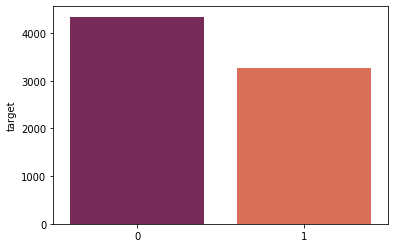

In [86]:
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(train_df['target'].value_counts().index,train_df['target'].value_counts(),palette='rocket')

In [85]:
train_df.loc[train_df['text'].str.contains('disaster',na=False, case=False)].target.value_counts()

train_df.loc[(train_df['text'].str.contains('disaster',na=False, case=False)) & (train_df['target'] == 0)].head()

,id,keyword,location,text,target
2781,3998,disaster,"Los Angeles, London, Kent",I forgot to bring chocolate with me. Major dis...,0
2783,4003,disaster,Portoviejo-Manabi-Ecuador,I'm a disaster?? https://t.co/VCV73BUaCZ,0
2784,4005,disaster,NaN,@LovelyLikeLaura I can see why one of your fav...,0
2786,4008,disaster,chillin at ceder rapids,Beautiful disaster // Jon McLaughlin is such a...,0
2789,4012,disaster,en el pais de los arrechos,beautiful disaster https://t.co/qm5Sz0fyU8,0


    Explore the Target Variable

In [87]:
# Example of a disaster tweet
disaster_tweets = train_df[train_df['target']==1]['text']
print("Disaster Tweet: ", disaster_tweets.values[1])

# Example of a disaster tweet
not_disaster_tweets = train_df[train_df['target']==0]['text']
print("Not a Disaster Tweet: ",not_disaster_tweets.values[1])

Disaster Tweet:  Forest fire near La Ronge Sask. Canada
Not a Disaster Tweet:  I love fruits


    Explore Keyword

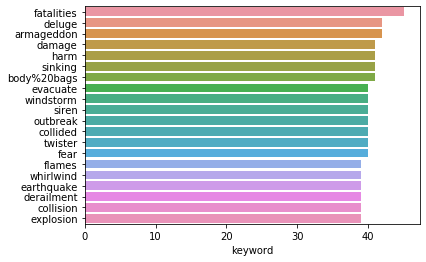

In [88]:
sns.barplot(y=train_df['keyword'].value_counts()[:20].index,x=train_df['keyword'].value_counts()[:20], orient='h')

    Explore location column

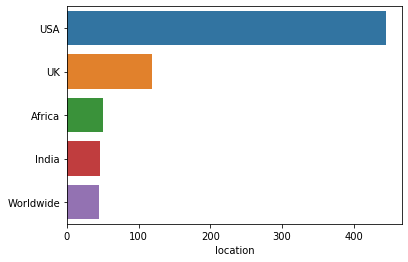

In [42]:
# Replacing the ambigious locations name with Standard names
train_df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train_df['location'].value_counts()[:5].index,x=train_df['location'].value_counts()[:5],
            orient='h')

# Data Preparation

## Sub heading

### subheading

In [43]:
# Repalce URLS
from spellchecker import SpellChecker
spell = SpellChecker()

def replace_URLS(text):
    url= re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'[URL]',text)

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def correct_mispelled_words(text):
    correct_text=[]
    incorrect_text = spell.unknown(text.split())
    for word in text.split():
        if word in incorrect_text:
            correct_text.append(spell.correction(word))
        else:
            correct_text.append(word)
    return " ".join(correct_text)

def text_preprocessing(df):
    df['text']=df['text'].apply(lambda x: replace_URLS(x))
    df['text']=df['text'].apply(lambda x: remove_emoji(x))
    df['text']=df['text'].apply(lambda x: correct_mispelled_words(x))
    return df

train_df_clean = text_preprocessing(train_df)

PermissionError: [Errno 13] Permission denied: 'review.csv'

In [76]:
##samp = train_df_clean.sample(25)
##generate_CSV(samp,"review")

## Issue 1 noted, some sort of unicode in the text:
issue_1 = "If YouÂ‰Ã›Âªre Not Paying Attention to Your Influencers YouÂ‰Ã›Âªre Burning Money | SocialTimes [URL]"

def other_issues(text):
    re.sub(r'Â‰',"",text)
    re.sub(r'Â‰',"",text)
    re.sub(r'Â‰Ã›Â',"'",text)
    return text


samp['text']=samp['text'].apply(lambda x: other_issues(x))

generate_CSV(samp,"review")  

In [90]:
## Data preparation code

import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("Tea is health and calming, don't you think? goes")

# Token in document
for token in doc:
    print(token)
    
# Reviewing Stop words and Lemmatization
print(f"Token \t\tLemma \t\tStopword".format('Token', 'Lemma', 'Stopword'))
print("-"*40)
for token in doc:
    print(f"{str(token)}\t\t{token.lemma_}\t\t{token.is_stop}")

Tea
is
health
and
calming
,
do
n't
you
think
?
goes
Token 		Lemma 		Stopword
----------------------------------------
Tea		tea		False
is		be		True
health		health		False
and		and		True
calming		calming		False
,		,		False
do		do		True
n't		not		False
you		-PRON-		True
think		think		False
?		?		False
goes		go		False


In [91]:
# Pattern matching 

from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)
terms = ['Galaxy Note','iPhone 11','iPhone XS', 'Google Pixel']
patterns=[nlp(text) for text in terms]
matcher.add("TerminologyList", None,*patterns)


In [92]:
import re
import string
import nltk
from nltk.corpus import stopwords

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?]','',text) ## remove punctuation
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+', '',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n','',text)
    text = re.sub('\w*\d\w*','',text)
    return text

# Applying the cleaning function to both test and training datasets
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train_df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [93]:
## Tokenize

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train_df['text'] = train_df['text'].apply(lambda x: tokenizer.tokenize(x))
test_df['text'] = test_df['text'].apply(lambda x: tokenizer.tokenize(x))

train_df['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [94]:
# remove stop words

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train_df['text'] = train_df['text'].apply(lambda x: remove_stopwords(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_stopwords(x))

train_df['text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [95]:
# Text Normalization
# Maybe use stemming or lemmatization?

In [96]:
# Combine text once preprocessing has been complete

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

train_df['text'] = train_df['text'].apply(lambda x: combine_text(x))
test_df['text'] = test_df['text'].apply(lambda x: combine_text(x))

In [97]:
#once preprocessing steps have been identified and complete, combine into one function such as below:
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [98]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

## BOW
bow_transform = CountVectorizer()
bow_train = bow_transform.fit_transform(train_df['text'])
bow_test = bow_transform.fit_transform(test_df['text'])

print(bow_train[0].todense()) #why?

## TFIDF
tfidf_transform = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf_train = tfidf_transform.fit_transform(train_df['text'])
tfidf_test = tfidf_transform.fit_transform(test_df['text'])

[[0 0 0 ... 0 0 0]]


# Modeling


In [99]:
## Modeling Code

In [100]:
# SKlearn
from sklearn import model_selection
from sklearn.metrics import f1_score
#from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
#from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [113]:
from sklearn.linear_model import LogisticRegression
## Logistic Regression Classifier
clf_bow = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_bow, bow_train, train_df['target'], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))
clf_bow.fit(bow_train, train_df["target"])

SCORES:  [0.59961686 0.48695652 0.57142857 0.5352381  0.6878475 ]

 AVERAGE OF SCORES:  0.5762175089315285

 STANDARD DEVIATION:  0.06734768609861866


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, tfidf_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))
clf_tfidf.fit(tfidf_train, train_df["target"])

SCORES:  [0.57692308 0.49394222 0.5399449  0.46715328 0.65302491]

 AVERAGE OF SCORES:  0.546197678857611

 STANDARD DEVIATION:  0.06538173177928776


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
from sklearn.naive_bayes import MultinomialNB
# Naive Bayes Classifier - BOW
clf_nb_bow = MultinomialNB()
scores = model_selection.cross_val_score(clf_nb_bow, bow_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

SCORES:  [0.63034367 0.60863309 0.68428571 0.64485981 0.72690217]

 AVERAGE OF SCORES:  0.6590048932449293

 STANDARD DEVIATION:  0.04197148501322356


In [104]:
clf_nb_bow.fit(bow_train,train_df["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [116]:
# Naive Bayes Classifier - TFIDF
clf_nb_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(clf_nb_tfidf, tfidf_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

SCORES:  [0.5703125  0.56177778 0.60542432 0.59906977 0.73979183]

 AVERAGE OF SCORES:  0.6152752401292334

 STANDARD DEVIATION:  0.0644168711257597


In [106]:
clf_nb_tfidf.fit(tfidf_train,train_df["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [117]:
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

clf_xgb_bow = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_bow, bow_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

SCORES:  [0.47690655 0.35976789 0.43575419 0.37248677 0.52901998]

 AVERAGE OF SCORES:  0.43478707743574363

 STANDARD DEVIATION:  0.0635043806181881


In [118]:
clf_xgb_tfidf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_tfidf, tfidf_train, train_df["target"], cv=5, scoring="f1")
print("SCORES: ", scores)
print("\n AVERAGE OF SCORES: ", np.mean(scores))
print("\n STANDARD DEVIATION: ", np.std(scores))

SCORES:  [0.49336283 0.34337349 0.43656716 0.39574468 0.56472795]

 AVERAGE OF SCORES:  0.44675522516726734

 STANDARD DEVIATION:  0.07678995838165309


# Evaluation


## F1 Score
The evaluation metric that the Kaggle competition uses is the F1 score. This paragraph is meant to define the F1 score and understand what contributes to this score.

According to [deepai.org](https://deepai.org/machine-learning-glossary-and-terms/f-score), the F1 score is the harmonic mean of the precision and recall.

[Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c), a blog published on Towards Data Science, authored by Will Koehresen helps us define each piece of the F1 Score.

Precision - the proportion of positive results that are truly positive. The calculation is the count of correctly identified disasters divided by every observation labeled as a disaster regardless of correctness. The score is penalized by the incorrectly labeled "disaster" observations .

Recall - measures the model's ability to identify true positives in a dataset. The true positives are divided by all positive instances, regardless of the model's ability to correctly identify them. This score is penalized by classifying true disasters observations as false (not a disaster).

![title](img/recall_df.png)
![title](img/precision_df.png)

In [109]:
def _recall(true_positives, false_negatives):
    return (true_positives)/(true_positives + false_negatives)
def _precision(true_positives, false_positives):
    return (true_positives)/(true_positives + false_positives)
def _f1(precision, recall):
    return (precision*recall)/(precision+recall)

In [110]:
print(train_df['target'].value_counts())

true_positives = 3171
total_observations = 7613
# If we were to hypothetically set all observations to DISASTER
false_positives = total_observations-true_positives
recall = _recall(true_positives,0)
precision = _precision(true_positives,false_positives)
print('\n\nIF ALL OBSERVATIONS WERE SET TO DISASTER (POSITIVE)')
print('RECALL: ', recall)
print('PRECISION: ', precision)
print('F1: ', _f1(precision, recall))

# If we were to hypothetically set all observations to NOT A DISASTER
print('\n\nIF ALL OBSERVATIONS WERE SET TO NOT DISASTER (NEGATIVE)')
print('RECALL: 0 ')
print('PRECISION: 0')
print('F1: 0')

# If we were to hypothetically set all observations to NOT A DISASTER but correctly identified 1 disaster
false_negatives = total_observations - 1
true_positives = 1
false_positives = 0
recall = _recall(true_positives,false_negatives)
precision = _precision(true_positives,false_positives)
print('\n\nIF ALL OBSERVATIONS WERE SET TO NOT DISASTER (NEGATIVE) But 1 correctly identified true positive')
print('RECALL: ', recall)
print('PRECISION: ', precision)
print('F1: ', _f1(precision, recall))

0    4342
1    3271
Name: target, dtype: int64


IF ALL OBSERVATIONS WERE SET TO DISASTER (POSITIVE)
RECALL:  1.0
PRECISION:  0.4165243662156837
F1:  0.2940467359050445


IF ALL OBSERVATIONS WERE SET TO NOT DISASTER (NEGATIVE)
RECALL: 0 
PRECISION: 0
F1: 0


IF ALL OBSERVATIONS WERE SET TO NOT DISASTER (NEGATIVE) But 1 correctly identified true positive
RECALL:  0.00013135426244581636
PRECISION:  1.0
F1:  0.00013133701076963486


To summarize the above findings: If we label all tweets as positive disasters, then we have a high recall because we identified all disasters, but a low precision because we also incorrectly labeled many non disasters as disasters. In contrast, if we identified one true positive, but labeled the rest negatives, then the precision is high because we didn't incorrectly identify any non disasters as disasters, but recall is low because we missed many true disasters.


Thinking about this from a cost/benefit perspective, if every tweet was labeled as a disaster (high recall, low precision), then the resources used to report and investigate the disaster is very costly. If ever tweet was labeled no disaster, then there is no benefit from using the model. Many true disasters are missed, which could cost the organization in their reputation from having a delayed reaction time to true emergencies. In this situation a true balance between recall and precision is desired.

A higher F1 score represents optimizing the balance between precision and recall.

## Confusion Matrix

## ROC Curve and AUC

# Deployment

In [111]:
## Deployment Code

In [40]:
def generate_CSV(df,file_name):
    file_name = file_name+".csv"
    df.to_csv(file_name, index=False)
    
#submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
#test_vectors=test_tfidf
#submission(submission_file_path,clf_NB_TFIDF,test_vectors)